In [1]:
# opengrid imports
from opengrid_dev.library import misc, houseprint, caching
from opengrid_dev.library.analysis import DailyAgg
from opengrid_dev import config
c=config.Config()

# other imports
import pandas as pd
import charts
import numpy as np
import os
import datetime as dt
import pytz
BXL = pytz.timezone('Europe/Brussels')


# configuration for the plots
DEV = c.get('env', 'type') == 'dev' # DEV is True if we are in development environment, False if on the droplet
print("Environment configured for development: {}".format(DEV))
if not DEV:
    # production environment: don't try to display plots
    import matplotlib
    matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.dates import MinuteLocator, HourLocator, DateFormatter, AutoDateLocator, num2date

if DEV:
    if c.get('env', 'plots') == 'inline':
        %matplotlib inline
    else:
        %matplotlib qt
else:
    pass # don't try to render plots
plt.rcParams['figure.figsize'] = 12,8

Server running in the folder /mnt/data/work/opengrid/code/og/notebooks/Analysis at 127.0.0.1:60450
Environment configured for development: True


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
hp = houseprint.Houseprint()
sensors = hp.get_sensors(sensortype='water') # sensor objects

hp.init_tmpo()

Opening connection to Houseprint sheet
Opening spreadsheets
Parsing spreadsheets
24 Sites created
24 Devices created
75 sensors created
Houseprint parsing complete
Using tmpo database from /mnt/data/work/opengrid/data/.tmpo/tmpo.sqlite3


In [3]:
hp.sync_tmpos()

/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:315: SNIMissingWarning: An HTTPS request has been made, but the SNI (Subject Name Indication) extension to TLS is not available on this platform. This may cause the server to present an incorrect TLS certificate, which can cause validation failures. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#snimissingwarning.
  SNIMissingWarning
/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:120: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/connection.py:266: SubjectAltNameWarning: Certificate for api.flukso.net has no `subjectAltName`, 

ConnectionError: HTTPSConnectionPool(host='api.flukso.net', port=443): Max retries exceeded with url: /sensor/06686f304bd7c72a86c3810d2965f4a2/tmpo/0/8/1461268736 (Caused by NewConnectionError('<requests.packages.urllib3.connection.VerifiedHTTPSConnection object at 0x7ff9606886d0>: Failed to establish a new connection: [Errno -2] Name or service not known',))

In [4]:
# The first time, this will take a very looong time to get all the detailed data for building the cache
# Afterwards, this is quick
caching.cache_results(hp=hp, sensors=sensors, resultname='water_mean', AnalysisClass=DailyAgg,  
                      agg='sum')

Cache object created for variable: water_mean


True

In [5]:
cache_water = caching.Cache(variable='water_mean')
dfday = cache_water.get(sensors=sensors)

Cache object created for variable: water_mean


In [6]:
# remove negatives
dfday = dfday[dfday>0]
dfday = dfday.resample('M', how='sum', label='left' )
dfday.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19 entries, 2014-09-30 to 2016-03-31
Freq: M
Data columns (total 8 columns):
661684d35cd07dfc657a60b844860785    19 non-null float64
b28509eb97137e723995838c393d49df    19 non-null float64
2923b75daf93e539e37ce5177c0008c5    19 non-null float64
a8054ca7865584e69a7c946aeea1e13c    19 non-null float64
1a5c55ec176d24483572aca420ac59b5    19 non-null float64
c57f45b21e2ec21ab427f172478e1ca4    13 non-null float64
a926bc966f178fc5d507a569a5bfc3d7    19 non-null float64
a519ce042e8748570d3a91cfca16a747    10 non-null float64
dtypes: float64(8)
memory usage: 1.3 KB


In [7]:
charts.plot(dfday, stock=True, show='inline')

In [8]:
standby_statistics = dfday.T.describe(percentiles=[0.1,0.5,0.9]).T

In [9]:
charts.plot(standby_statistics[['10%', '50%', '90%']], stock=True, show='inline')

### Percentile approach.  Useful for longer time periods, but tweaking of graph still needed

In [10]:
# choose a period
now = pd.Timestamp('now', tz=BXL)
dt_start_of_last_day = pd.Timestamp(dfday.index[-1].date(), tz=BXL)
look_back_days = 400
dt_start_of_period = dt_start_of_last_day - pd.Timedelta(days=look_back_days-1)
dfday_period = dfday.ix[dt_start_of_period:].dropna(axis=1, how='all')
df = dfday_period.join(standby_statistics[['10%', '50%', '90%']], how='left')
df = df.ix[:-1]

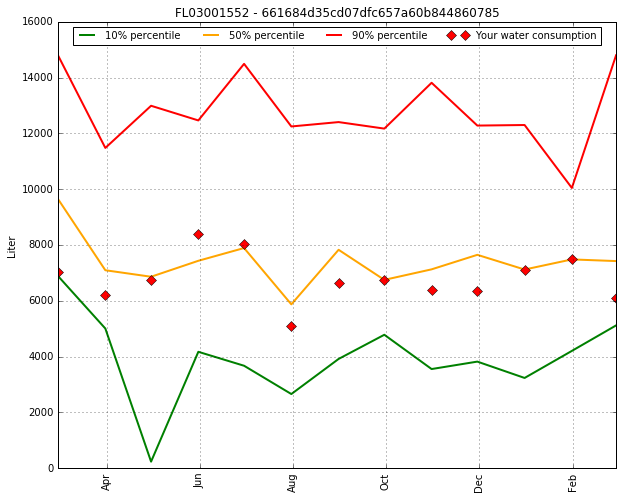

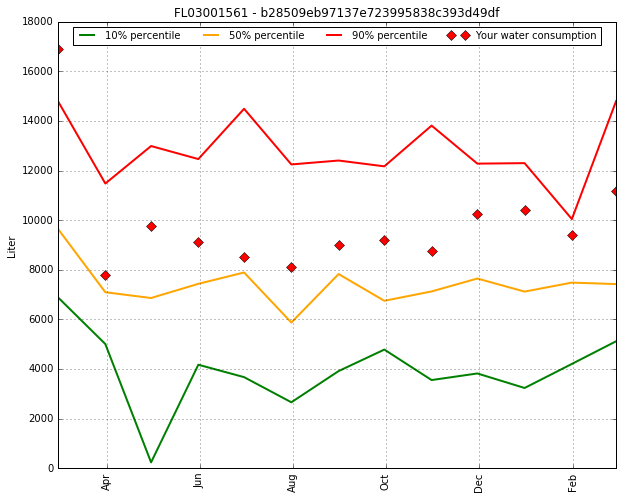

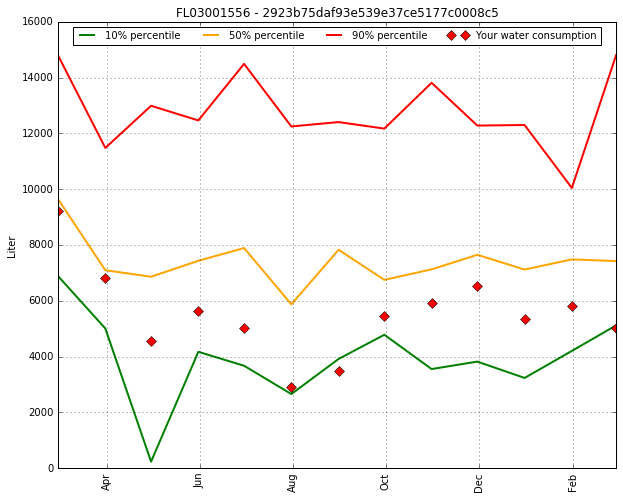

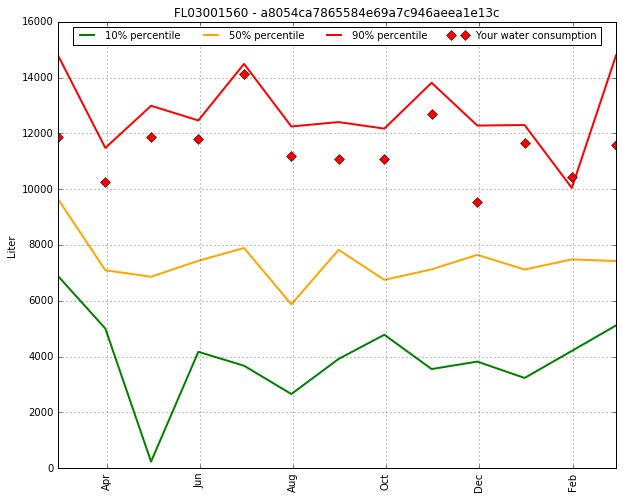

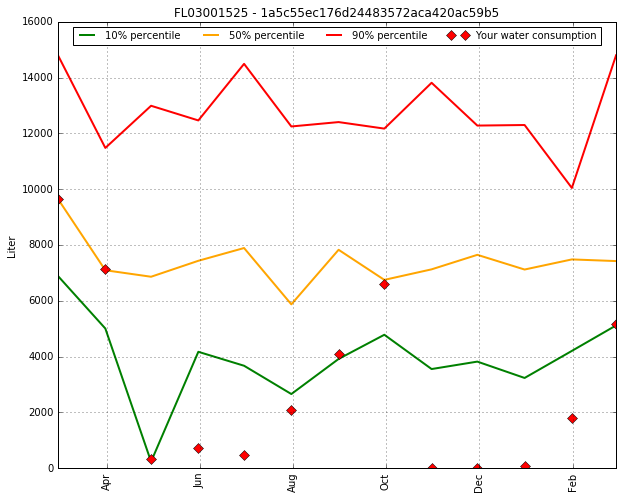

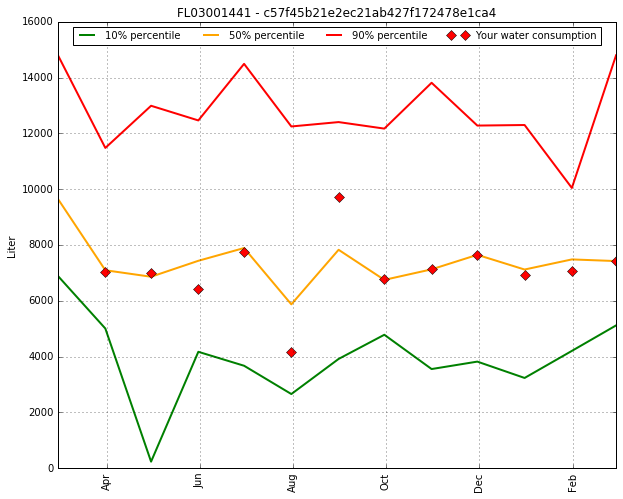

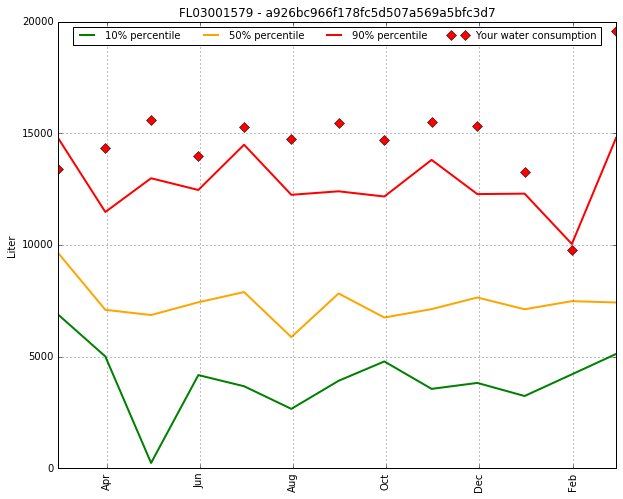

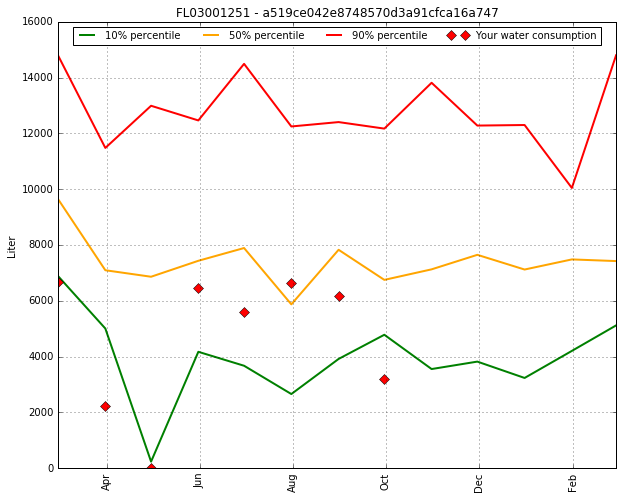

In [11]:
for sensor in dfday_period.columns:
    try:
        plt.figure(figsize=(10,8))
        ax1=plt.subplot()
        ax1.plot_date(df.index, df[u'10%'], '-', lw=2, color='g', label=u'10% percentile')
        ax1.plot_date(df.index, df[u'50%'], '-', lw=2, color='orange', label=u'50% percentile')
        ax1.plot_date(df.index, df[u'90%'], '-', lw=2, color='r', label=u'90% percentile')
        ax1.plot_date(df.index, df[sensor], 'rD', ms=7, label='Your water consumption') 
        ax1.legend(loc='upper center', ncol=4, prop={'size':10})
        locs, lables=plt.xticks()
        xticks = [x.strftime(format='%b') for x in num2date(locs)]
        plt.xticks(locs, xticks, rotation='vertical')
        plt.title(hp.find_sensor(sensor).device.key + ' - ' + sensor)
        ax1.grid()
        ax1.set_ylabel('Liter')

    
    except Exception as e:
        print(e)
    else:
        plt.savefig(os.path.join(c.get('data', 'folder'), 'figures', 'daily_water_'+sensor+'.png'), dpi=100)
        pass
    if not DEV:
        plt.close()